In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from sklearn.model_selection import train_test_split
import time

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as transform
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix

#import copy
#import cv2
#from PIL import Image
 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32
print_every = 100

In [2]:
path = './chest_xray'

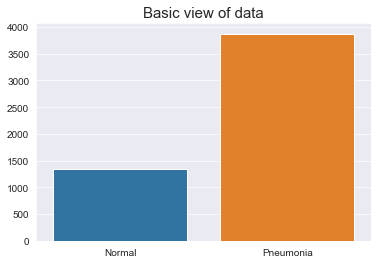

In [3]:
normal_length = 0
pneumonia_length = 0
for filename in os.listdir(path+'/train/NORMAL'):
    normal_length += 1
for filename in os.listdir(path+'/train/PNEUMONIA'):
    pneumonia_length += 1
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [normal_length], 
     'Pneumonia': [pneumonia_length]})

sns.set_style('darkgrid')
sns.barplot(data=train_samplesize).set_title('Basic view of data', fontsize=15)
plt.show()

In [4]:
def data_transforms(phase = None):
    
    if phase == TRAIN:

        data_T = transform.Compose([
            
                transform.Resize(size = (256,256)),
                transform.RandomRotation(degrees = (-20,+20)),
                transform.CenterCrop(size=224),
                #Might add transform.RandomHorizontalFlip(),
                transform.ToTensor(),
                transform.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    
    elif phase == TEST or phase == VAL:

        data_T = transform.Compose([

                transform.Resize(size = (224,224)),
                transform.ToTensor(),
                transform.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
    return data_T

In [5]:
TEST = 'test'
TRAIN = 'train'
VAL ='val'

trainset = ImageFolder(os.path.join(path, TRAIN),transform = data_transforms(TRAIN))
testset = ImageFolder(os.path.join(path, TEST),transform = data_transforms(TEST))
validset = ImageFolder(os.path.join(path, VAL),transform = data_transforms(VAL))

In [6]:
class_names = trainset.classes
print(class_names)
print(trainset.class_to_idx)

trainloader = DataLoader(trainset,batch_size = 64,shuffle = True)
validloader = DataLoader(validset,batch_size = 64,shuffle = True)
testloader = DataLoader(testset,batch_size = 64,shuffle = True)

print(len(trainloader))
print(len(validloader))
print(len(testloader))

images, labels = iter(trainloader).next()
print(images.shape)
print(labels.shape)

['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}
82
1
10
torch.Size([64, 3, 224, 224])
torch.Size([64])


In [7]:
images

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

In [8]:
labels

tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [9]:
#for i, (images,labels) in enumerate(trainloader):
#        if torch.cuda.is_available():
#            images=Variable(images.cuda())
#            labels=Variable(labels.cuda())
            
#images.shape, labels.shape

In [10]:
images, labels = iter(trainloader).next()
images.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [11]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [12]:
class Attention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv_query = nn.Conv2d(in_channels, in_channels, kernel_size = 1)
        self.conv_key = nn.Conv2d(in_channels, in_channels, kernel_size = 1)
        self.conv_value = nn.Conv2d(in_channels, in_channels, kernel_size = 1)

    def forward(self, x):
        N, C, H, W = x.shape
        
        q = self.conv_query(x).reshape(N,C,H*W)
        k = self.conv_key(x).reshape(N,C,H*W)
        v = self.conv_value(x).reshape(N,C,H*W)
        attention = F.softmax(q @ k.transpose(1,2) / (C**(1/2)), dim = 2)
        attention = attention @ v
        attention = attention.reshape(N, C, H, W)
        return x + attention

In [13]:
class easy_conv(nn.Module):
    def __init__(self,num_classes=2):
        super(easy_conv,self).__init__()
        
        #A very easy 3 conv network
         
        self.conv1=nn.Conv2d(in_channels=3, out_channels=15, kernel_size=3, stride=1, padding=1)
        self.relu =nn.ReLU()   
        self.bn1=nn.BatchNorm2d(num_features=15)
       
        self.maxpool=nn.MaxPool2d(kernel_size=2)
        
        self.conv2=nn.Conv2d(in_channels=15,out_channels=24,kernel_size=3,stride=1,padding=1)
        self.bn2=nn.BatchNorm2d(num_features=24)
        
        self.conv3=nn.Conv2d(in_channels=24,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        
        self.linear1=nn.Linear(in_features=32 * 56 * 56,out_features=num_classes)
    def forward(self,input):
        output=self.conv1(input)
        output=self.relu(output)
        output=self.maxpool(output)
        output=self.bn1(output)
        
        output=self.conv2(output)
        output=self.relu(output)
        output=self.maxpool(output)
        output=self.bn2(output)
        
        output=self.conv3(output)
        output=self.relu(output) 
        output=self.bn3(output)
        
        output=flatten(output)
        output=self.linear1(output)
        
        return output
    

In [14]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

#Below is a ResidualBlock|
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, have_downsample = False, batchNorm = False):
        super(ResidualBlock, self).__init__()
        self.have_downsample = have_downsample
        self.batchNorm = batchNorm
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample_conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.downsample_bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out) if self.batchNorm else out
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out) if self.batchNorm else out
        if self.have_downsample:
            residual = self.downsample_conv(x)
            residual = self.downsample_bn(residual) if self.batchNorm else residual
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    
    def __init__(self, block_size, num_classes=2, batchNorm = True, attention = False):
        super(ResNet, self).__init__()
        self.batchNorm = batchNorm
        self.conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.in_channels = 64
        self.layer1 = self.construct_layer(64, block_size[0], batchNorm = batchNorm)
        self.layer2 = self.construct_layer(128, block_size[1], have_downsample = True, batchNorm = batchNorm)
        self.attention = attention
        self.ATT1 = Attention(64)
        self.layer3 = self.construct_layer(256, block_size[2], have_downsample = True, batchNorm = batchNorm)
        self.layer4 = self.construct_layer(512, block_size[3], stride = 2, have_downsample = True, batchNorm = batchNorm)
        self.avg_pool = nn.AvgPool2d(4)
        self.linear = nn.Linear(512 * 7 * 7, num_classes)
        #self.softmax = nn.Softmax(dim = 0)
        
    def construct_layer(self, out_channels, layer, stride=1, have_downsample = False, batchNorm = False):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, have_downsample = have_downsample, batchNorm = batchNorm))
        self.in_channels = out_channels
        for i in range(1, layer):
            layers.append(ResidualBlock(out_channels, out_channels)) #additional part for further usage
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn1(out) if self.batchNorm else out
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        if self.attention:
            out = self.ATT1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = flatten(out)
        out = self.linear(out)
        return out
    

In [15]:
class VGG(nn.Module):
    
    def __init__(self, block_size, num_classes=2, attention = False):
        super(VGG, self).__init__()
        self.attention = attention
        self.layer1 = self.construct_layer(3, 64, block_size[0])
        self.layer2 = self.construct_layer(64, 128, block_size[1])
        self.ATT = Attention(128)
        self.layer3 = self.construct_layer(128, 256, block_size[2])
        self.layer4 = self.construct_layer(256, 512, block_size[3])
        self.layer5 = self.construct_layer(512, 512, block_size[4])
        self.linear1 = nn.Linear(7*7*512, 4096)
        self.relu = nn.ReLU(inplace = True)
        self.drop = nn.Dropout(0.5)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, num_classes)
        #self.softmax = nn.Softmax(dim = 0)
        
    def construct_layer(self, in_channels, out_channels, layer):
        layers = []
        layers.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace = True)
        ))
        for i in range(1, layer):
            layers.append(nn.Sequential(
                nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace = True))) #additional part for further usage
        layers.append(nn.MaxPool2d(2, stride = 2))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        if self.attention:
            out = self.ATT(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = flatten(out)
        out = self.linear1(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.linear3(out)
        return out



#model = VGG([2, 2, 3,3,3]).to(device)

In [16]:
def Conv1(in_planes, places, stride=2):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_planes,out_channels=places,kernel_size=7,stride=stride,padding=3, bias=False),
        nn.BatchNorm2d(places),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

class _TransitionLayer(nn.Module):
    def __init__(self, inplace, plance):
        super(_TransitionLayer, self).__init__()
        self.transition_layer = nn.Sequential(
            nn.BatchNorm2d(inplace),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=inplace,out_channels=plance,kernel_size=1,stride=1,padding=0,bias=False),
            nn.AvgPool2d(kernel_size=2,stride=2),
        )

    def forward(self, x):
        return self.transition_layer(x)


class _DenseLayer(nn.Module):
    def __init__(self, inplace, growth_rate, bn_size, drop_rate=0):
        super(_DenseLayer, self).__init__()
        self.drop_rate = drop_rate
        self.dense_layer = nn.Sequential(
            nn.BatchNorm2d(inplace),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=inplace, out_channels=bn_size * growth_rate, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(bn_size * growth_rate),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=bn_size * growth_rate, out_channels=growth_rate, kernel_size=3, stride=1, padding=1, bias=False),
        )
        self.dropout = nn.Dropout(p=self.drop_rate)

    def forward(self, x):
        y = self.dense_layer(x)
        if self.drop_rate > 0:
            y = self.dropout(y)
        return torch.cat([x, y], 1)


class DenseBlock(nn.Module):
    def __init__(self, num_layers, inplances, growth_rate, bn_size , drop_rate=0):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(_DenseLayer(inplances + i * growth_rate, growth_rate, bn_size, drop_rate))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


class DenseNet(nn.Module):
    def __init__(self, init_channels=64, growth_rate=32, blocks=[6, 12, 24, 16], num_classes=2, attention = False):
        super(DenseNet, self).__init__()
        bn_size = 4
        drop_rate = 0
        self.conv1 = Conv1(in_planes=3, places=init_channels)
        self.attention = attention

        num_features = init_channels
        self.layer1 = DenseBlock(num_layers=blocks[0], inplances=num_features, growth_rate=growth_rate, bn_size=bn_size, drop_rate=drop_rate)
        num_features = num_features + blocks[0] * growth_rate
        self.transition1 = _TransitionLayer(inplace=num_features, plance=num_features // 2)
        num_features = num_features // 2
        self.layer2 = DenseBlock(num_layers=blocks[1], inplances=num_features, growth_rate=growth_rate, bn_size=bn_size, drop_rate=drop_rate)
        num_features = num_features + blocks[1] * growth_rate
        self.transition2 = _TransitionLayer(inplace=num_features, plance=num_features // 2)
        num_features = num_features // 2
        self.ATT = Attention(num_features)
        self.layer3 = DenseBlock(num_layers=blocks[2], inplances=num_features, growth_rate=growth_rate, bn_size=bn_size, drop_rate=drop_rate)
        num_features = num_features + blocks[2] * growth_rate
        self.transition3 = _TransitionLayer(inplace=num_features, plance=num_features // 2)
        num_features = num_features // 2
        self.layer4 = DenseBlock(num_layers=blocks[3], inplances=num_features, growth_rate=growth_rate, bn_size=bn_size, drop_rate=drop_rate)
        num_features = num_features + blocks[3] * growth_rate

        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.conv1(x)

        x = self.layer1(x)
        x = self.transition1(x)
        x = self.layer2(x)
        x = self.transition2(x)
        if self.attention:
            x = self.ATT(x)
        x = self.layer3(x)
        x = self.transition3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def DenseNet121():
    return DenseNet(init_channels=64, growth_rate=32, blocks=[6, 12, 24, 16])

def DenseNet161():
    return DenseNet(init_channels=64, growth_rate=32, blocks=[6, 12, 32, 32])

def DenseNet201():
    return DenseNet(init_channels=64, growth_rate=32, blocks=[6, 12, 48, 32])

def DenseNet264():
    return DenseNet(init_channels=64, growth_rate=32, blocks=[6, 12, 64, 48])

In [17]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

In [18]:
def train_part(model, optimizer, epochs, loss_history, acc_valid_history, acc_train_history, get_every_train_acc):
    model = model.to(device=device)
    for e in range(epochs):
        for t, (x, y) in enumerate(trainloader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            

            if t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                loss_history.append(loss.item())
                print('Checking validation accuracy')
                acc_valid = check_accuracy(validloader, model)
                acc_valid_history.append(acc_valid)
                if get_every_train_acc:
                    print('Checking training accuracy')
                    acc_train = check_accuracy(trainloader, model)
                    acc_train_history.append(acc_train)
                print()

In [18]:
#In this case, we didn't change the label and index to Variable. So the accuracy may decrease. We do this to compare the result to the 
# ResNet-10 Result below 

loss_history =[]
acc_valid_history = [] 
acc_train_history = []
model_easy = None
optimizer = None
model_easy = easy_conv()
optimizer = optim.SGD(model_easy.parameters(), lr=0.005,
                     momentum=0.9, nesterov=True)
if torch.cuda.is_available():
    print("available")
    model_easy = model_easy.cuda()

train_part(model_easy, optimizer, 8, loss_history, acc_valid_history, acc_train_history, False)

available
Epoch 0, Iteration 0, loss = 0.7342
Checking validation accuracy
Got 8 / 16 correct (50.00)

Epoch 1, Iteration 0, loss = 0.2885
Checking validation accuracy
Got 9 / 16 correct (56.25)

Epoch 2, Iteration 0, loss = 0.1724
Checking validation accuracy
Got 8 / 16 correct (50.00)

Epoch 3, Iteration 0, loss = 0.1161
Checking validation accuracy
Got 10 / 16 correct (62.50)

Epoch 4, Iteration 0, loss = 0.0914
Checking validation accuracy
Got 10 / 16 correct (62.50)

Epoch 5, Iteration 0, loss = 0.0582
Checking validation accuracy
Got 10 / 16 correct (62.50)

Epoch 6, Iteration 0, loss = 0.0312
Checking validation accuracy
Got 8 / 16 correct (50.00)

Epoch 7, Iteration 0, loss = 0.2505
Checking validation accuracy
Got 8 / 16 correct (50.00)



### The accuray below is for the simple 3 conv network. 

In [13]:
check_accuracy(testloader, model_easy)

Got 514 / 624 correct (82.37)


0.8237179487179487

# ResNet

In [24]:
model = None
optimizer = None
loss_history =[]
acc_valid_history = [] 
acc_train_history = []
model = ResNet([1, 1, 1, 1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
if torch.cuda.is_available():
    print("available")
    model = model.cuda()

train_part(model, optimizer, 10, loss_history, acc_valid_history, acc_train_history, True)
Resnet10_No_ATT = model

available
Epoch 0, Iteration 0, loss = 0.6858
Checking validation accuracy
Got 8 / 16 correct (50.00)

Epoch 1, Iteration 0, loss = 0.2830
Checking validation accuracy
Got 9 / 16 correct (56.25)

Epoch 2, Iteration 0, loss = 0.1651
Checking validation accuracy
Got 12 / 16 correct (75.00)

Epoch 3, Iteration 0, loss = 0.0935
Checking validation accuracy
Got 9 / 16 correct (56.25)

Epoch 4, Iteration 0, loss = 0.0611
Checking validation accuracy
Got 10 / 16 correct (62.50)

Epoch 5, Iteration 0, loss = 0.1599
Checking validation accuracy
Got 8 / 16 correct (50.00)

Epoch 6, Iteration 0, loss = 0.0724
Checking validation accuracy
Got 11 / 16 correct (68.75)

Epoch 7, Iteration 0, loss = 0.1102
Checking validation accuracy
Got 9 / 16 correct (56.25)



### The accuray below is for the ResNet_10 network (w/o TL, w/o Attention). 

In [25]:
check_accuracy(testloader, model)

Got 504 / 624 correct (80.77)


0.8076923076923077

In [23]:
model = None
optimizer = None
loss_history =[]
acc_valid_history = [] 
acc_train_history = []
model = ResNet([1, 1, 1, 1], attention = True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
if torch.cuda.is_available():
    print("available")
    model = model.cuda()

train_part(model, optimizer, 10, loss_history, acc_valid_history, acc_train_history, True)
Resnet10_ATT = model

available
Epoch 0, Iteration 0, loss = 0.6977
Checking validation accuracy
Got 8 / 16 correct (50.00)
Checking training accuracy
Got 3875 / 5216 correct (74.29)

Epoch 1, Iteration 0, loss = 0.2716
Checking validation accuracy
Got 11 / 16 correct (68.75)
Checking training accuracy
Got 4679 / 5216 correct (89.70)

Epoch 2, Iteration 0, loss = 0.1573
Checking validation accuracy
Got 9 / 16 correct (56.25)
Checking training accuracy
Got 4869 / 5216 correct (93.35)

Epoch 3, Iteration 0, loss = 0.3439
Checking validation accuracy
Got 9 / 16 correct (56.25)
Checking training accuracy
Got 4891 / 5216 correct (93.77)

Epoch 4, Iteration 0, loss = 0.1946
Checking validation accuracy
Got 8 / 16 correct (50.00)
Checking training accuracy
Got 4874 / 5216 correct (93.44)

Epoch 5, Iteration 0, loss = 0.1882
Checking validation accuracy
Got 8 / 16 correct (50.00)
Checking training accuracy
Got 4934 / 5216 correct (94.59)

Epoch 6, Iteration 0, loss = 0.1024
Checking validation accuracy
Got 10 / 16 

### The accuray below is for the ResNet_10 network (w/o TL, w Attention). 

In [24]:
check_accuracy(testloader, Resnet10_ATT)

Got 543 / 624 correct (87.02)


0.8701923076923077

In [31]:
model = None
optimizer = None
loss_history =[]
acc_valid_history = [] 
acc_train_history = []
model = ResNet([3, 4, 6, 3]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
if torch.cuda.is_available():
    print("available")
    model = model.cuda()

train_part(model, optimizer, 10, loss_history, acc_valid_history, acc_train_history, True)

available
Epoch 0, Iteration 0, loss = 0.6828
Checking validation accuracy
Got 8 / 16 correct (50.00)
Checking training accuracy
Got 3875 / 5216 correct (74.29)

Epoch 1, Iteration 0, loss = 0.3451
Checking validation accuracy
Got 8 / 16 correct (50.00)
Checking training accuracy
Got 3875 / 5216 correct (74.29)

Epoch 2, Iteration 0, loss = 0.1053
Checking validation accuracy
Got 10 / 16 correct (62.50)
Checking training accuracy
Got 4774 / 5216 correct (91.53)

Epoch 3, Iteration 0, loss = 0.4266
Checking validation accuracy
Got 10 / 16 correct (62.50)
Checking training accuracy
Got 4666 / 5216 correct (89.46)

Epoch 4, Iteration 0, loss = 0.1142
Checking validation accuracy
Got 10 / 16 correct (62.50)
Checking training accuracy
Got 4799 / 5216 correct (92.01)

Epoch 5, Iteration 0, loss = 0.0880
Checking validation accuracy
Got 11 / 16 correct (68.75)
Checking training accuracy
Got 4891 / 5216 correct (93.77)

Epoch 6, Iteration 0, loss = 0.1122
Checking validation accuracy
Got 10 / 

### The accuray below is for the ResNet_50 network. (w/o TL, w/o Attention)

In [32]:
check_accuracy(testloader, model)

Got 531 / 624 correct (85.10)


0.8509615384615384

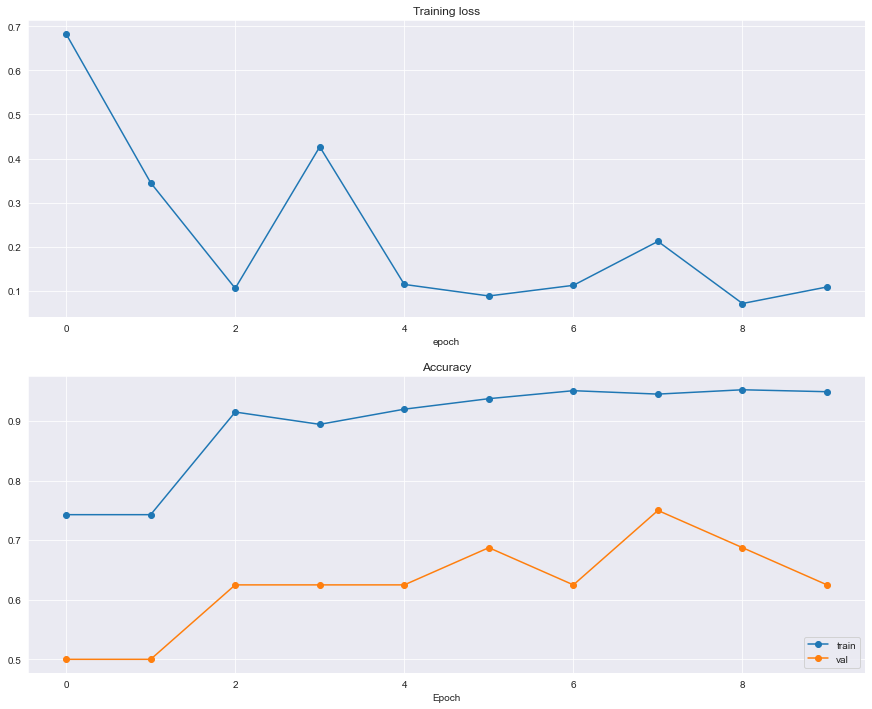

In [37]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(loss_history, '-o')
plt.xlabel('epoch')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(acc_train_history, '-o', label='train')
plt.plot(acc_valid_history, '-o', label='val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [27]:
resnet50 = models.resnet50(pretrained=True)
for param in resnet50.parameters():
    param.requires_grad = False

final_in_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(final_in_features, 2)
resnet50 = resnet50.to(device)

In [28]:
model = None
optimizer = None
loss_history =[]
acc_valid_history = [] 
acc_train_history = []

#Note that the code above applies VGG network designed by ourself, however due to cuda out of memory. We are not able to directly apply it and we try it on another computer to record the data

model = resnet50
optimizer = optim.Adam(model.parameters(), lr=0.001)
if torch.cuda.is_available():
    print("available")
    model = model.cuda()

train_part(model, optimizer, 10, loss_history, acc_valid_history, acc_train_history, True)
resnet50_pretrianed = model

available
Epoch 0, Iteration 0, loss = 0.7991
Checking validation accuracy
Got 8 / 16 correct (50.00)
Checking training accuracy
Got 3875 / 5216 correct (74.29)

Epoch 1, Iteration 0, loss = 0.1977
Checking validation accuracy
Got 15 / 16 correct (93.75)
Checking training accuracy
Got 4856 / 5216 correct (93.10)

Epoch 2, Iteration 0, loss = 0.1285
Checking validation accuracy
Got 16 / 16 correct (100.00)
Checking training accuracy
Got 4931 / 5216 correct (94.54)

Epoch 3, Iteration 0, loss = 0.1067
Checking validation accuracy
Got 14 / 16 correct (87.50)
Checking training accuracy
Got 4952 / 5216 correct (94.94)

Epoch 4, Iteration 0, loss = 0.1048
Checking validation accuracy
Got 14 / 16 correct (87.50)
Checking training accuracy
Got 4962 / 5216 correct (95.13)

Epoch 5, Iteration 0, loss = 0.0785
Checking validation accuracy
Got 16 / 16 correct (100.00)
Checking training accuracy
Got 4967 / 5216 correct (95.23)

Epoch 6, Iteration 0, loss = 0.1112
Checking validation accuracy
Got 16

### The accuray below is for the ResNet_50 network. (TL)

In [31]:
check_accuracy(testloader, resnet50_pretrianed)

Got 489 / 624 correct (78.37)


0.7836538461538461

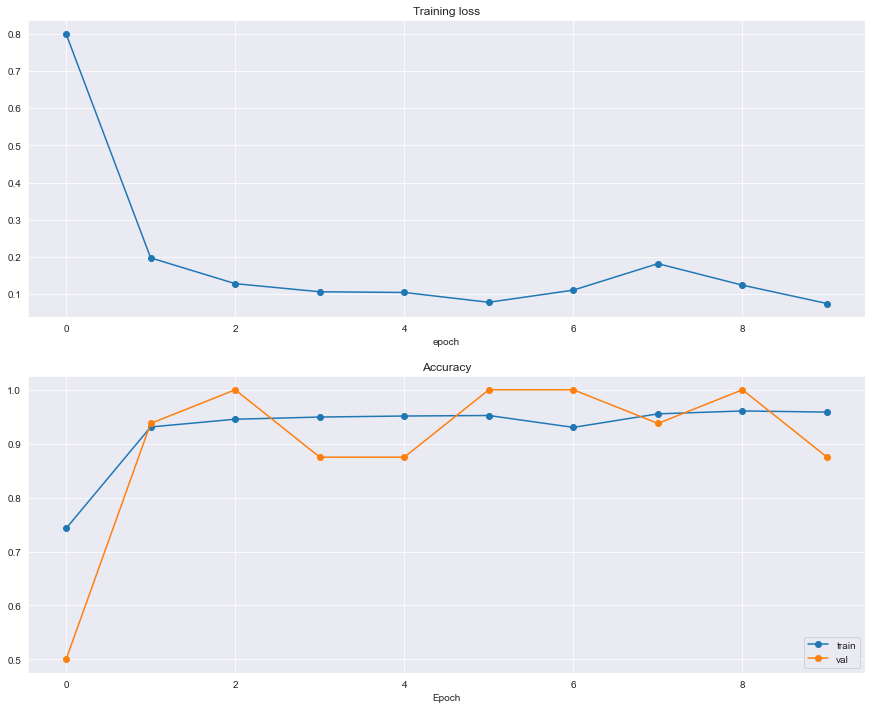

In [32]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(loss_history, '-o')
plt.xlabel('epoch')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(acc_train_history, '-o', label='train')
plt.plot(acc_valid_history, '-o', label='val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [19]:
model = None
optimizer = None
loss_history =[]
acc_valid_history = [] 
acc_train_history = []
model = ResNet([3, 4, 6, 3], attention = True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)
if torch.cuda.is_available():
    print("available")
    model = model.cuda()

train_part(model, optimizer, 10, loss_history, acc_valid_history, acc_train_history, True)
resnet50_attention = model

available
Epoch 0, Iteration 0, loss = 0.5334
Checking validation accuracy
Got 8 / 16 correct (50.00)
Checking training accuracy
Got 1341 / 5216 correct (25.71)

Epoch 1, Iteration 0, loss = 0.2799
Checking validation accuracy
Got 10 / 16 correct (62.50)
Checking training accuracy
Got 4355 / 5216 correct (83.49)

Epoch 2, Iteration 0, loss = 0.2033
Checking validation accuracy
Got 8 / 16 correct (50.00)
Checking training accuracy
Got 2928 / 5216 correct (56.13)

Epoch 3, Iteration 0, loss = 0.1608
Checking validation accuracy
Got 10 / 16 correct (62.50)
Checking training accuracy
Got 4684 / 5216 correct (89.80)

Epoch 4, Iteration 0, loss = 0.1167
Checking validation accuracy
Got 9 / 16 correct (56.25)
Checking training accuracy
Got 4773 / 5216 correct (91.51)

Epoch 5, Iteration 0, loss = 0.1444
Checking validation accuracy
Got 7 / 16 correct (43.75)
Checking training accuracy
Got 3068 / 5216 correct (58.82)

Epoch 6, Iteration 0, loss = 0.1659
Checking validation accuracy
Got 10 / 16

### The accuray below is for the ResNet_50 network. (Attention)

In [20]:
check_accuracy(testloader, resnet50_attention)

Got 511 / 624 correct (81.89)


0.8189102564102564

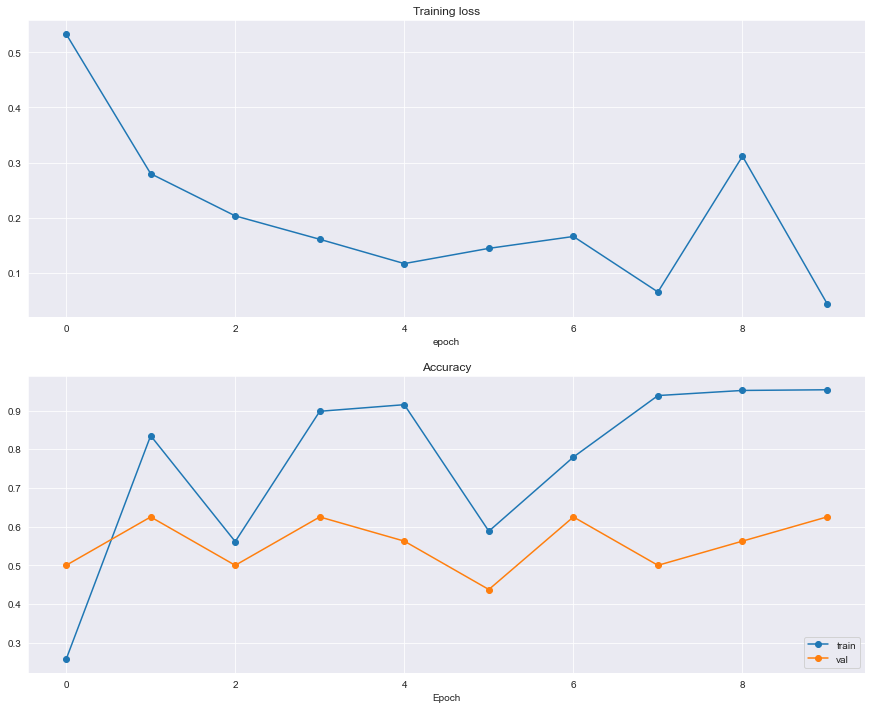

In [21]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(loss_history, '-o')
plt.xlabel('epoch')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(acc_train_history, '-o', label='train')
plt.plot(acc_valid_history, '-o', label='val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# VGG (pretrained and not pretrained)

In [5]:
vgg = models.vgg16_bn(pretrained=True)
for param in vgg.parameters():
    param.requires_grad = False

final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, 2)
vgg = vgg.to(device)

In [31]:
#Notation: Cuda out of memory on my machine, so I test VGG without transfer learning on other's computer.

model = None
optimizer = None
loss_history =[]
acc_valid_history = [] 
acc_train_history = []
#model = VGG([2, 2, 3, 3, 3]).to(device)
#Note that the code above applies VGG network designed by ourself, however due to cuda out of memory. We are not able to directly apply it and we try it on another computer to record the data

model = vgg
optimizer = optim.Adam(model.parameters(), lr=0.001)
if torch.cuda.is_available():
    print("available")
    model = model.cuda()

train_part(model, optimizer, 10, loss_history, acc_valid_history, acc_train_history, True)

available
Epoch 0, Iteration 0, loss = 0.2460
Checking validation accuracy
Got 13 / 16 correct (81.25)
Checking training accuracy
Got 4869 / 5216 correct (93.35)

Epoch 1, Iteration 0, loss = 0.2069
Checking validation accuracy
Got 14 / 16 correct (87.50)
Checking training accuracy
Got 4966 / 5216 correct (95.21)

Epoch 2, Iteration 0, loss = 0.0881
Checking validation accuracy
Got 12 / 16 correct (75.00)
Checking training accuracy
Got 4963 / 5216 correct (95.15)

Epoch 3, Iteration 0, loss = 0.2902
Checking validation accuracy
Got 11 / 16 correct (68.75)
Checking training accuracy
Got 4975 / 5216 correct (95.38)

Epoch 4, Iteration 0, loss = 0.1078
Checking validation accuracy
Got 12 / 16 correct (75.00)
Checking training accuracy
Got 4963 / 5216 correct (95.15)

Epoch 5, Iteration 0, loss = 0.1788
Checking validation accuracy
Got 11 / 16 correct (68.75)
Checking training accuracy
Got 4975 / 5216 correct (95.38)

Epoch 6, Iteration 0, loss = 0.1484
Checking validation accuracy
Got 13 

### The accuray below is for the VGG network (pretrained / transfer learning). 

In [22]:
check_accuracy(testloader, model)

Got 518 / 624 correct (83.01)


0.8301282051282052

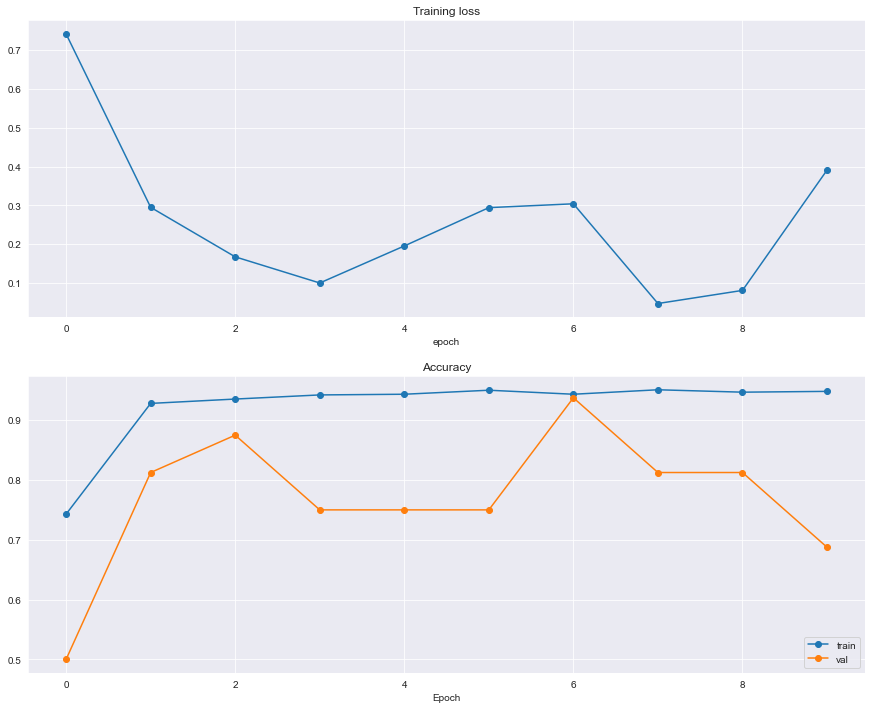

In [23]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(loss_history, '-o')
plt.xlabel('epoch')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(acc_train_history, '-o', label='train')
plt.plot(acc_valid_history, '-o', label='val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# DenseNet161

In [26]:
densenet161 = models.densenet161(pretrained=True)
for param in densenet161.parameters():
    param.requires_grad = False

final_in_features = densenet161.classifier.in_features
densenet161.classifier = nn.Linear(final_in_features, 2)
densenet161 = densenet161.to(device)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to C:\Users\Hp/.cache\torch\hub\checkpoints\densenet161-8d451a50.pth
21.2%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

52.3%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

82.7%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookAp

In [27]:
model = None
optimizer = None
loss_history =[]
acc_valid_history = [] 
acc_train_history = []
model = densenet161
optimizer = optim.Adam(model.parameters(), lr=0.001)
if torch.cuda.is_available():
    print("available")
    model = model.cuda()

train_part(model, optimizer, 10, loss_history, acc_valid_history, acc_train_history, True)

available
Epoch 0, Iteration 0, loss = 0.7224
Checking validation accuracy
Got 8 / 16 correct (50.00)
Checking training accuracy
Got 3867 / 5216 correct (74.14)

Epoch 1, Iteration 0, loss = 0.3218
Checking validation accuracy
Got 14 / 16 correct (87.50)
Checking training accuracy
Got 4932 / 5216 correct (94.56)

Epoch 2, Iteration 0, loss = 0.1774
Checking validation accuracy
Got 11 / 16 correct (68.75)
Checking training accuracy
Got 4987 / 5216 correct (95.61)

Epoch 3, Iteration 0, loss = 0.1426
Checking validation accuracy
Got 11 / 16 correct (68.75)
Checking training accuracy
Got 5013 / 5216 correct (96.11)

Epoch 4, Iteration 0, loss = 0.1803
Checking validation accuracy
Got 12 / 16 correct (75.00)
Checking training accuracy
Got 5019 / 5216 correct (96.22)

Epoch 5, Iteration 0, loss = 0.0300
Checking validation accuracy
Got 12 / 16 correct (75.00)
Checking training accuracy
Got 5013 / 5216 correct (96.11)

Epoch 6, Iteration 0, loss = 0.1128
Checking validation accuracy
Got 11 /

### The accuray below is for the densenet161 network (pretrained / transfer learning). 

In [28]:
check_accuracy(testloader, model)

Got 550 / 624 correct (88.14)


0.8814102564102564

In [29]:
#Note that because of cuda momory is limited. Desnenet 161 network w/p TL and attention are tested on other GPU environment. Here we only 
#show Desnenet 161(together with attention) implementation code.

# Dense121

In [29]:
densenet121 = models.densenet121(pretrained=True)
for param in densenet121.parameters():
    param.requires_grad = False

final_in_features = densenet121.classifier.in_features
densenet121.classifier = nn.Linear(final_in_features, 2)
densenet121 = densenet121.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\Hp/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
76.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [30]:
model = None
optimizer = None
loss_history =[]
acc_valid_history = [] 
acc_train_history = []
model = densenet121
optimizer = optim.Adam(model.parameters(), lr=0.001)
if torch.cuda.is_available():
    print("available")
    model = model.cuda()

train_part(model, optimizer, 10, loss_history, acc_valid_history, acc_train_history, True)
densenet121_after_train = model

available
Epoch 0, Iteration 0, loss = 0.5391
Checking validation accuracy
Got 8 / 16 correct (50.00)
Checking training accuracy
Got 3872 / 5216 correct (74.23)

Epoch 1, Iteration 0, loss = 0.2236
Checking validation accuracy
Got 14 / 16 correct (87.50)
Checking training accuracy
Got 4857 / 5216 correct (93.12)

Epoch 2, Iteration 0, loss = 0.2142
Checking validation accuracy
Got 13 / 16 correct (81.25)
Checking training accuracy
Got 4891 / 5216 correct (93.77)

Epoch 3, Iteration 0, loss = 0.2076
Checking validation accuracy
Got 14 / 16 correct (87.50)
Checking training accuracy
Got 4938 / 5216 correct (94.67)

Epoch 4, Iteration 0, loss = 0.1283
Checking validation accuracy
Got 15 / 16 correct (93.75)
Checking training accuracy
Got 4915 / 5216 correct (94.23)

Epoch 5, Iteration 0, loss = 0.1187
Checking validation accuracy
Got 14 / 16 correct (87.50)
Checking training accuracy
Got 4973 / 5216 correct (95.34)

Epoch 6, Iteration 0, loss = 0.1506
Checking validation accuracy
Got 15 /

### The accuray below is for the densenet121 network (pretrained / transfer learning). 

In [33]:
check_accuracy(testloader, model)

Got 548 / 624 correct (87.82)


0.8782051282051282

In [ ]:
#Note that because of cuda momory is limited. Desnenet 121 network w/p TL and attention are tested on other GPU environment. Here we only 
#show Desnenet 121(together with attention) implementation code.

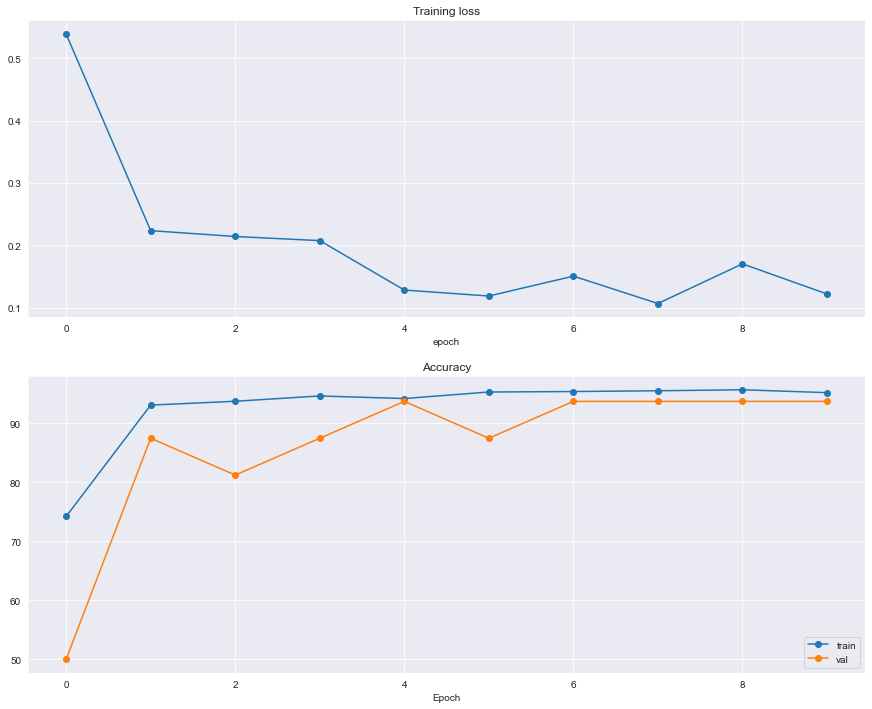

In [35]:
#loss_history = [0.5391, 0.2236, 0.2142, 0.2076, 0.1283, 0.1187, 0.1506, 0.1067, 0.1703, 0.1220]
#acc_train_history = [74.23, 93.12, 93.77, 94.67, 94.23, 95.34, 95.42, 95.55, 95.72, 95.23]
#acc_valid_history = [50.00, 87.50, 81.25, 87.50, 93.75, 87.50, 93.75, 93.75, 93.75, 93.75]

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(loss_history, '-o')
plt.xlabel('epoch')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(acc_train_history, '-o', label='train')
plt.plot(acc_valid_history, '-o', label='val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [42]:
model = None
optimizer = None
loss_history =[]
acc_valid_history = [] 
acc_train_history = []
model = DenseNet121()
optimizer = optim.Adam(model.parameters(), lr=0.001)
if torch.cuda.is_available():
    print("available")
    model = model.cuda()

train_part(model, optimizer, 10, loss_history, acc_valid_history, acc_train_history, True)
densenet121_wo_TL = model

available
